# iShame Coffee Video Pre-Processing

This notebook walks through the process to prepare training and test data for the iShame CNN model. Training data consists of videos of coffee pots in various states of fullness. Videos are decomposed in to invidual frames and associated with the appropriate label. Data is then split in to train and test sets, and saved in h5 format.

In [16]:
import os
import glob
import json
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import h5py
import cv2

First, we retrieve the set of videos in the input folder, which are saved with their class label. We create a dictionary assocating the file path to the video with the appropriate label.

In [17]:
video_dir = '../img/video/raw'
videos = []
labels = set()
for video in glob.glob(os.path.join(video_dir,"*.mp4")):
    label = os.path.splitext(os.path.basename(video))[0]
    path = video
    videos.append({"label": label, "path": path})
    labels.add(label)

Classes are label encoded, and stored in a dictionary for reference. 

For each video, we decompose it in to its individual frames. For each frame, we load it as a numpy array using OpenCV, then resize it. Then, we attach the numpy array and the lable to the image_data and image_labels arrays. 

All frame pre-processing would occur in this step. Potential transformations that we are considering include conversion to HSV color space (instead of RGB), resizing, adding noise, etc.

In [18]:
labels = sorted(labels)
label_dict = {idx:label for idx,label in enumerate(labels)}
reverse_label_dict = {label:idx for idx,label in enumerate(labels)}
image_data = []
image_labels = []

frame_save_path = '../img/video/frames'
scale_factor = 0.5
save_every_n = 1

def process_videos(videos, save_path, convert_to_hsv=False):

    for video in videos:
        vidcap = cv2.VideoCapture(video['path'])
        label = video['label']
        label_enc = reverse_label_dict[label]
        success = True
        count = 0
        while success:
            success, image = vidcap.read()
            if count % save_every_n == 0:
                print('Processing image ', count)
                if convert_to_hsv:
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                print('Original Image Shape:',image.shape)
                resized_image = cv2.resize(image,(int(image.shape[1]*scale_factor), int(image.shape[0]*scale_factor)))
                print('Resized Image Shape:',resized_image.shape)
                image_data.append(resized_image)
                image_labels.append(label_enc)
                # cv2.imwrite(os.path.join(save_path, "{}_label_{}_frame_{}.jpg".format(video['label'],label_enc,count)),image)
            count += 1


In [19]:
process_videos(videos, frame_save_path,convert_to_hsv=True)

 Image Shape: (540, 960, 3)
Processing image  274
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  275
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  276
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  277
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  278
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  279
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  280
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  281
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  282
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  283
Original Image Shape: (1080, 1920, 3)
Resized Image Shape: (540, 960, 3)
Processing image  284


error: /build/opencv-L2vuMj/opencv-3.2.0+dfsg/modules/imgproc/src/color.cpp:9815: error: (-215) (scn == 3 || scn == 4) && (depth == CV_8U || depth == CV_32F) in function cvtColor


Let's check the dimensions of our image data and labels.

In [21]:
print("Image Data Examples:",len(image_data))
print("Number of Image Labels:",len(image_labels))
print("Image Dimensions:", image_data[0].shape)
print("Last Image:",image_data[-1])
print("Last Image Label:",image_labels[-1])


Image Data Examples: 484
Number of Image Labels: 484
Image Dimensions: (540, 960, 3)
Last Image: [[[ 93  22 105]
  [ 93  22 107]
  [ 99  24 106]
  ...
  [ 53  23  90]
  [ 45  23  89]
  [ 45  22  94]]

 [[ 93  21 107]
  [ 93  21 108]
  [ 99  24 106]
  ...
  [ 53  11  95]
  [ 38  11  96]
  [ 38  11  93]]

 [[ 93  22 104]
  [ 93  22 106]
  [ 99  24 107]
  ...
  [ 30   6  91]
  [ 30   6  92]
  [ 30   6  92]]

 ...

 [[ 98  44  64]
  [ 98  45  64]
  [ 98  44  64]
  ...
  [102  66 100]
  [102  66 100]
  [102  66 100]]

 [[ 98  43  65]
  [ 98  43  65]
  [ 98  43  65]
  ...
  [102  68  98]
  [102  68  98]
  [102  68  98]]

 [[ 98  48  59]
  [ 98  48  59]
  [ 98  48  59]
  ...
  [102  69  97]
  [102  69  96]
  [102  70  96]]]
Last Image Label 0


We use scikit-learn's "train_test_split" method to split our data set in to train (80%) and test (20%) sets. 

In [22]:
train_data, test_data, train_labels, test_labels = train_test_split(image_data, image_labels, test_size=0.2, shuffle=True, random_state=42)
print(len(train_data),len(train_labels))
print(len(test_data),len(test_labels))

387 387
97 97


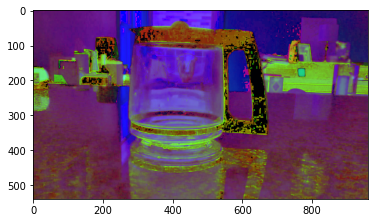

In [9]:
# show single image
plt.imshow(train_data[20])

In [10]:
# concatenate train data and test data in to a single numpy array
train_data = np.stack(train_data, axis=0)
print(train_data.shape)
test_data = np.stack(test_data, axis=0)
print(test_data.shape)


(387, 540, 960, 3)
(97, 540, 960, 3)


In [11]:
# normalize image data
train_data = train_data/255.
test_data = test_data/255.

In [12]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [13]:
# make labels in to numpy arrays, one-hot encoded
train_labels = convert_to_one_hot(np.array(train_labels,ndmin=2),len(labels))
print(train_labels.shape)
test_labels = convert_to_one_hot(np.array(test_labels,ndmin=2),len(labels))
print(test_labels.shape)


(387, 3)
(97, 3)


In [14]:
print(train_labels[0])
print(test_labels[20])


[1. 0. 0.]
[1. 0. 0.]


In [15]:
# save dataset
data_save_path = '../img/label_data'
data_set_name='coffee_label_data.h5'
filepath=os.path.join(data_save_path,data_set_name)

if(os.path.exists(filepath)):
    os.remove(filepath)
coffee_data = h5py.File(filepath,'w')
coffee_data.create_dataset('train_data', data=train_data)
coffee_data.create_dataset('test_data', data=test_data)
coffee_data.create_dataset('train_labels', data=train_labels)
coffee_data.create_dataset('test_labels', data=test_labels)
coffee_data.close()


Next steps:
Data Augmentation
Pre-processing (Color space, resizing, noise, etc.)